In [7]:
# from get_links import links_on_page
import numpy as np
import pandas as pd
import requests
import re
import networkx as nx
import matplotlib.pyplot as plt
import nltk
import sklearn
from bs4 import BeautifulSoup
from tqdm import tqdm
tqdm.pandas()
from animal_list import names_from_table
from netwulf import visualize
from wordcloud import WordCloud
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
animal_names = names_from_table()
animal_names_set = set(animal_names.values())
# lower case all names
animal_names_set = set([x.lower() for x in animal_names_set])

# read txt file with pandas
animal_df = pd.read_csv('data/animal_links.txt', header=None)
animal_df.columns = ['page-name']

# remove the first part of the url
animal_df['page-name'] = animal_df['page-name'].str.replace('https://en.wikipedia.org', '', regex=False)
animal_df["name"] = animal_df["page-name"].str.split("/").str[-1]

# lower case everything
animal_df["name"] = animal_df["name"].str.lower()
animal_df["page-name"] = animal_df["page-name"].str.lower()




In [9]:
# animal_names
animal_df

# load in reptile dataset just for testing purposes
with open('data/data_plain_reptile.pickle', 'rb') as handle:
    pa = pickle.load(handle)
with open('data/data_plain_long_reptile.pickle', 'rb') as handle:
    pb = pickle.load(handle)


pb

{('Balkan_pond_turtle', 'Northern_river_terrapin'): 1,
 ('Balkan_pond_turtle', 'Amboina_box_turtle'): 1,
 ('Balkan_pond_turtle', 'Indochinese_box_turtle'): 1,
 ('Balkan_pond_turtle', 'McCord%27s_box_turtle'): 1,
 ('Balkan_pond_turtle', 'Pan%27s_box_turtle'): 1,
 ('Balkan_pond_turtle', 'Golden_coin_turtle'): 1,
 ('Balkan_pond_turtle', 'Yellow-headed_box_turtle'): 1,
 ('Balkan_pond_turtle', 'Yunnan_box_turtle'): 1,
 ('Balkan_pond_turtle', 'Zhou%27s_box_turtle'): 1,
 ('Balkan_pond_turtle', 'Asian_leaf_turtle'): 1,
 ('Balkan_pond_turtle', 'Western_black-bridged_leaf_turtle'): 1,
 ('Balkan_pond_turtle', 'Black_pond_turtle'): 3,
 ('Balkan_pond_turtle', 'Black-breasted_leaf_turtle'): 1,
 ('Balkan_pond_turtle', 'Brahminy_river_turtle'): 3,
 ('Balkan_pond_turtle', 'Arakan_forest_turtle'): 1,
 ('Balkan_pond_turtle', 'Giant_Asian_pond_turtle'): 1,
 ('Balkan_pond_turtle', 'Spiny_turtle'): 1,
 ('Balkan_pond_turtle', 'Mekong_snail-eating_turtle'): 1,
 ('Balkan_pond_turtle', 'Japanese_pond_turtle'): 

## Helper functions

In [10]:
# create function that will run on each row in the dataframe, which will take the page name and return all the readable text on the page
def get_text(page_name):
    url = 'https://en.wikipedia.org' + page_name
    response = requests.get(url)
    html_content = response.content
    soup = BeautifulSoup(html_content, 'html.parser')
    # Find all the paragraphs in the body
    paragraphs = soup.body.find_all('p')
    # Extract the text from the paragraphs but remove \n
    # text = [p.text for p in paragraphs]
    text = [str(p.text.replace('\n', '')).strip() for p in paragraphs]
    # Join the paragraphs together
    joined_text = ' '.join(text)
    # remove first space
    joined_text = joined_text[1:]
    return joined_text

# function that can be passed to the tf-idf vectorizer that will preprocess the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

# function we will apply to the tf-idf matrix to get the top n words
def get_top_words(row, n=300):
    return row.sort_values(ascending=False).head(n).to_dict()

# generate wordcloud
def generate_wordcloud(tf_idf:dict):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(tf_idf)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig('wordcloud.png', dpi=300, bbox_inches='tight')
    plt.show()

In [11]:
# we will define a function to do all the steps above - tf-idf, get top words and return a dictionary with this information

def get_information_dict(filepath:str, load=True, save=False, preprocess=True) -> dict:
    """
    Function that will read a parquet file, or csv file, or json file, or pickle file, and return a dictionary with the dataframe, top words and tf-idf matrix

    Parameters
    ----------
    filepath : str
        The name of the file to read
    load : bool, optional
        Whether to load the file or not. The default is True. Can only be used if the file is already made, have to have run with save as True before
    save : bool, optional
        Whether to save the file or not. The default is False
    preprocess : bool, optional
        Whether to preprocess the text or not. The default is True
    
    Returns
    -------
    dict
        A dictionary with the dataframe, top words and tf-idf matrix

    
    
    
    
    
    """
    print(f"Reading {filepath}")
    # get the filepath before the extension
    filepath_without_extension = filepath.split('.')[0]
    if filepath.endswith('.parquet'):
        df = pd.read_parquet(filepath)
    elif filepath.endswith('.csv'):
        df = pd.read_csv(filepath)
    elif filepath.endswith('.json'):
        df = pd.read_json(filepath)
    elif filepath.endswith('long_reptile.pickle'):
        with open('data/data_plain_long_reptile.pickle', 'rb') as handle:
            a = pickle.load(handle)
        b = {str(k[0]).lower() for k, v in a.items()}
        c = {str(k[1]).lower() for k, v in a.items()}
        d = b.union(c)
        df = animal_df[animal_df['name'].isin(d)].reset_index(drop=True)

    elif filepath.endswith('reptile.pickle'):
        with open('data/data_plain_reptile.pickle', 'rb') as handle:
            a = pickle.load(handle)
        b = {str(k[0]).lower(): v for k, v in a.items()}
        df = animal_df[animal_df['page-name'].isin(b.keys())].reset_index(drop=True)
    
    if load:
        try:
            df = pd.read_parquet(filepath_without_extension + '.parquet')
        except FileNotFoundError:
            print(f"File {filepath} not found")
            return
    else:
        # get the text from the page
        print(f"Getting text")
        df['text'] = df['page-name'].progress_apply(get_text)

    if save:
        # save as parquet file
        df.to_parquet(filepath_without_extension + '.parquet')
    
    if preprocess:
        vectorizer = TfidfVectorizer(stop_words='english', dtype=np.float32, preprocessor=preprocess_text)
    else:
        vectorizer = TfidfVectorizer(stop_words='english', dtype=np.float32)
    
    tfidf_matrix = vectorizer.fit_transform(df['text'])
    feature_names = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns=feature_names)
    
    print(f"Getting top words")
    top_words = tfidf_df.progress_apply(get_top_words, axis=1)
    top_words.index = df['name']

    if save:
        # save as a json file
        top_words.to_json(filepath_without_extension + '_top_words.json')
    
    return {'df': df, 'top_words': top_words, 'tfidf_df': tfidf_df}
    
    
        
            
        

In [12]:
data_dict_reptile_long = get_information_dict('data/data_plain_long_reptile.pickle', load=True, save=True, preprocess=True)
data_dict_reptile = get_information_dict('data/data_plain_reptile.pickle', load=True, save=True, preprocess=True)

Reading data/data_plain_long_reptile.pickle
Getting text


100%|██████████| 1063/1063 [10:30<00:00,  1.68it/s]


Getting top words


100%|██████████| 1063/1063 [00:01<00:00, 577.36it/s]


Reading data/data_plain_reptile.pickle
Getting top words


100%|██████████| 4344/4344 [00:08<00:00, 488.35it/s]


In [37]:
# We want to check the score of the words in the top words for each animal
# We will do this by getting the tf-idf score for each word in the top words for each animal


for name, top_words in data_dict_reptile['top_words'].items():
    tw_keys = set([k for k, value in top_words.items() if value > 0]) # get the keys of the top words that have a score > 0

    links = list(animal_names_set.intersection(tw_keys))
    if links:
        link_dict = {name: {k: top_words[k]} for k in links}
        
        # add to the df
        # 
        data_dict_reptile['df'].loc[data_dict_reptile['df']['name'] == name, 'links'] = str(link_dict[name])

In [38]:
data_dict_reptile["df"]
# data_dict_reptile["top_words"]

,page-name,name,text,links
0,/wiki/chironius_laurenti,chironius_laurenti,Chironius laurenti is a species of nonvenomous...,NaN
1,/wiki/dasia_olivacea,dasia_olivacea,"Dasia olivacea, the olive dasia or olive tree ...",{'skink': 0.05847395211458206}
2,/wiki/alabama_map_turtle,alabama_map_turtle,The Alabama map turtle (Graptemys pulchra) is ...,{'turtle': 0.27575668692588806}
3,/wiki/geoscincus,geoscincus,Geoscincus is a monotypic genus of skinks: the...,{'skink': 0.11515277624130249}
4,/wiki/gonyosoma_oxycephalum,gonyosoma_oxycephalum,"Elaphe oxycephala (Boie, 1827) Gonyosoma oxyce...",NaN
...,...,...,...,...
4339,/wiki/eugongylus_albofasciolatus,eugongylus_albofasciolatus,The white-striped cape skink or barred shark s...,{'lizard': 0.07265761494636536}
4340,/wiki/eumecia_johnstoni,eumecia_johnstoni,Eumecia johnstoni is a species of skink found ...,{'skink': 0.22512587904930115}
4341,/wiki/giant_plated_lizard,giant_plated_lizard,The giant plated lizard (Matobosaurus validus)...,{'lizard': 0.22714518010616302}
4342,/wiki/eutropis_multicarinata,eutropis_multicarinata,Eutropis multicarinata is a species of skink f...,{'skink': 0.2291412651538849}


![alternatvie text](figures/network.png)

Above the graph of the network can be seen for the file data_plain_reptile which tracks how many times all the pages refer back to the 224 long list of animals (main animals). We see a clear clustering around the nodes: Lizard, Skink, Turtle, Snake and Gecko to name the largest. Let us investigate if we can see a link for some of the nodes in these clusters through our text analysis


We will look at the animal laudakia_dayana which can faintly be seen in the lizard cluster.
The result can be seen below where lizard comes in at the 20th place according to tf-idf score and can also be seen in the wordcloud

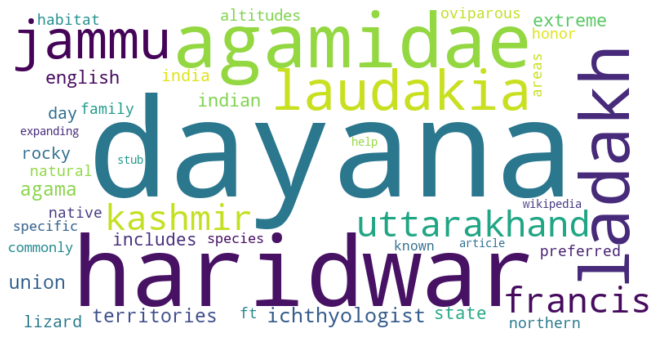

{'dayana': 0.7781180739402771,
 'haridwar': 0.3264921307563782,
 'agamidae': 0.17940571904182434,
 'ladakh': 0.14602045714855194,
 'laudakia': 0.14602045714855194,
 'jammu': 0.137184739112854,
 'uttarakhand': 0.1349705010652542,
 'francis': 0.12666435539722443,
 'kashmir': 0.12536734342575073,
 'ichthyologist': 0.12415406852960587,
 'territories': 0.10556888580322266,
 'agama': 0.1051366925239563,
 'union': 0.10199619829654694,
 'extreme': 0.09168355166912079,
 'indian': 0.08808277547359467,
 'english': 0.08808277547359467,
 'includes': 0.07648512721061707,
 'state': 0.07445795089006424,
 'rocky': 0.07048151642084122,
 'day': 0.06949358433485031,
 'lizard': 0.06937794387340546,
 'india': 0.06880073249340057,
 'altitudes': 0.06345445662736893,
 'areas': 0.05691749230027199,
 'native': 0.05564678832888603,
 'northern': 0.05519157648086548,
 'preferred': 0.054572246968746185,
 'family': 0.05417335778474808,
 'ft': 0.05264384299516678,
 'natural': 0.050990644842386246,
 'habitat': 0.048375

In [39]:
sample_name = 'laudakia_dayana'
generate_wordcloud(data_dict_reptile["top_words"][sample_name])
data_dict_reptile["top_words"][sample_name]

Let us investigate another one. This time geophis_fulvoguttatus which can be seen in the snake cluster
Our hypothesis is that it also can be seen in the wordcloud and in the td-idf score

The wordcloud and the top words below indicate that there is quite a strong connection with this sample to snake, being the 3rd highest ranked. But we also see that there is not many words on the page at all, only about 15 in total

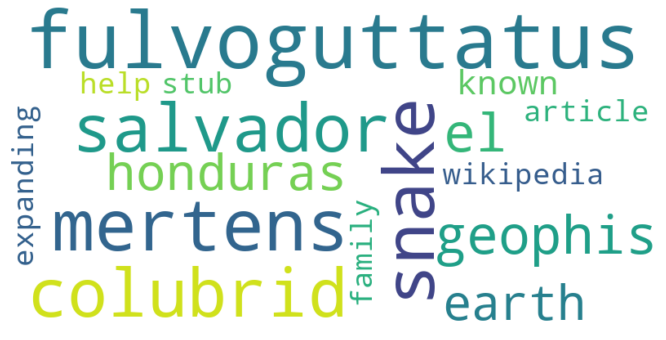

{'fulvoguttatus': 0.44143447279930115,
 'mertens': 0.3592900335788727,
 'snake': 0.3421878516674042,
 'colubrid': 0.3206845819950104,
 'salvador': 0.3119744658470154,
 'geophis': 0.2958552837371826,
 'el': 0.2914089560508728,
 'honduras': 0.2734665274620056,
 'earth': 0.2560710310935974,
 'known': 0.09993358701467514,
 'wikipedia': 0.07793111354112625,
 'stub': 0.07791164517402649,
 'expanding': 0.0777173787355423,
 'article': 0.07762051373720169,
 'family': 0.07683277130126953,
 'help': 0.07669943571090698,
 'peyriéras': 0.0,
 'peyrierasi': 0.0,
 'peyrieras': 0.0,
 'petén': 0.0,
 'petty': 0.0,
 'petteri': 0.0,
 'petted': 0.0,
 'petsmart': 0.0,
 'pets': 0.0,
 'persevere': 0.0,
 'petrodroma': 0.0,
 'petroleum': 0.0,
 'peña': 0.0,
 'petrii': 0.0,
 'petricolus': 0.0,
 'petricola': 0.0,
 'petri': 0.0,
 'petracola': 0.0,
 'petra': 0.0,
 'petitions': 0.0,
 'petitioned': 0.0,
 'petition': 0.0,
 'petiti': 0.0,
 'persecution': 0.0,
 'persicus': 0.0,
 'persia': 0.0,
 'peñón': 0.0,
 'phayrei': 0.

In [40]:
sample_name = 'geophis_fulvoguttatus'
generate_wordcloud(data_dict_reptile["top_words"][sample_name])
data_dict_reptile["top_words"][sample_name]

In [41]:
data_dict_reptile_long["df"]
# data_dict_reptile["df"]

,page-name,name,text
0,/wiki/alabama_map_turtle,alabama_map_turtle,The Alabama map turtle (Graptemys pulchra) is ...
1,/wiki/geoscincus,geoscincus,Geoscincus is a monotypic genus of skinks: the...
2,/wiki/gharial,gharial,"The gharial (Gavialis gangeticus), also known ..."
3,/wiki/oriental_garden_lizard,oriental_garden_lizard,The oriental garden lizard (Calotes versicolor...
4,/wiki/common_collared_lizard,common_collared_lizard,The common collared lizard (Crotaphytus collar...
...,...,...,...
759,/wiki/japanese_pond_turtle,japanese_pond_turtle,"The Japanese pond turtle (Mauremys japonica), ..."
760,/wiki/pygmy_mulga_monitor,pygmy_mulga_monitor,"The pygmy mulga monitor (Varanus gilleni), als..."
761,/wiki/bothrops_jararaca,bothrops_jararaca,Bothrops jararaca — known as the jararaca[4] o...
762,/wiki/djokoiskandarus,djokoiskandarus,"Cantoria annulata de Jong, 1926 Djokoiskandaru..."


In [42]:
animal_df["name"] == "northern_river_terrapin"

0        False
1        False
2        False
3        False
4        False
         ...  
31749    False
31750    False
31751    False
31752    False
31753    False
Name: name, Length: 31754, dtype: bool